## Построение графа попарного косинусного сходства векторизированных чанков документа 

### Установка зависимостей

In [ ]:
# установка langchain зависимостей
%pip install langchain langchain-community langchain-text-splitters langchain-huggingface langchain-chroma

In [ ]:
# установка остального по
%pip install pypdf textwrap unstructured networkx numpy matplotlib

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from langchain_core.documents import Document
import textwrap

def preview_doc(doc: Document, max_length=100):
  '''Метод для сжатия вывода контента документов.'''
  short_metadata = textwrap.shorten(str(doc.metadata), width=max_length, placeholder='…')
  short_content = textwrap.shorten(doc.page_content, width=max_length, placeholder='…')
  return f"Document(metadata={short_metadata}, page_content='{short_content}')"

### Подготовка данных

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# загружаем PDF файл
loader = PyPDFLoader('https://www.cs.princeton.edu/~arvindn/publications/OpenWPM_1_million_site_tracking_measurement.pdf')
pages = loader.load()
preview_doc(pages[0])

"Document(metadata={'producer': 'pdfTeX-1.40.16', 'creator': 'LaTeX with hyperref package', 'creationdate':…, page_content='Online Tracking: A 1-million-site Measurement and Analysis Steven Englehardt Princeton University…')"

In [ ]:
from unstructured.cleaners.core import clean

# зачищаем текст от мусора
for page in pages:
  page.page_content = clean(page.page_content, extra_whitespace=True, dashes=True, bullets=True, lowercase=False)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# разбиваем PDF на чанки
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(pages)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

# выбираем модель для создания эмбеддингов
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

embedding_model = HuggingFaceEmbeddings(
  model_name=model_name,
  model_kwargs=model_kwargs,
  encode_kwargs=encode_kwargs
)

In [ ]:
from uuid import uuid4

# считаем эмбеддинги
embeddings = embedding_model.embed_documents([doc.page_content for doc in splits])
# и нумеруем
embeddings_pack = [(uuid4(), embedding) for embedding in embeddings]

### Считаем попарное косинусное сходство

In [ ]:
import numpy as np

def cosine_similarity(X, Y=None):
  if Y is None:
    Y = X

  X = np.array(X)
  Y = np.array(Y)
  X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
  Y_norm = Y / np.linalg.norm(Y, axis=1, keepdims=True)
  return np.dot(X_norm, Y_norm.T)


sim_matrix = cosine_similarity(embeddings)

### Строим граф

In [ ]:
import networkx as nx

G = nx.Graph()

# загоняем чанки как узлы
for (id, embedding) in embeddings_pack:
  G.add_node(id)

THRESHOLD = 0.68

# добавляем рёбра, если сходство выше порога
n = len(embeddings_pack)
for i in range(n):
  for j in range(i + 1, n):
    if sim_matrix[i, j] > THRESHOLD:
      G.add_edge(embeddings_pack[i][0], embeddings_pack[j][0], weight=sim_matrix[i, j])

### Выводим на экран

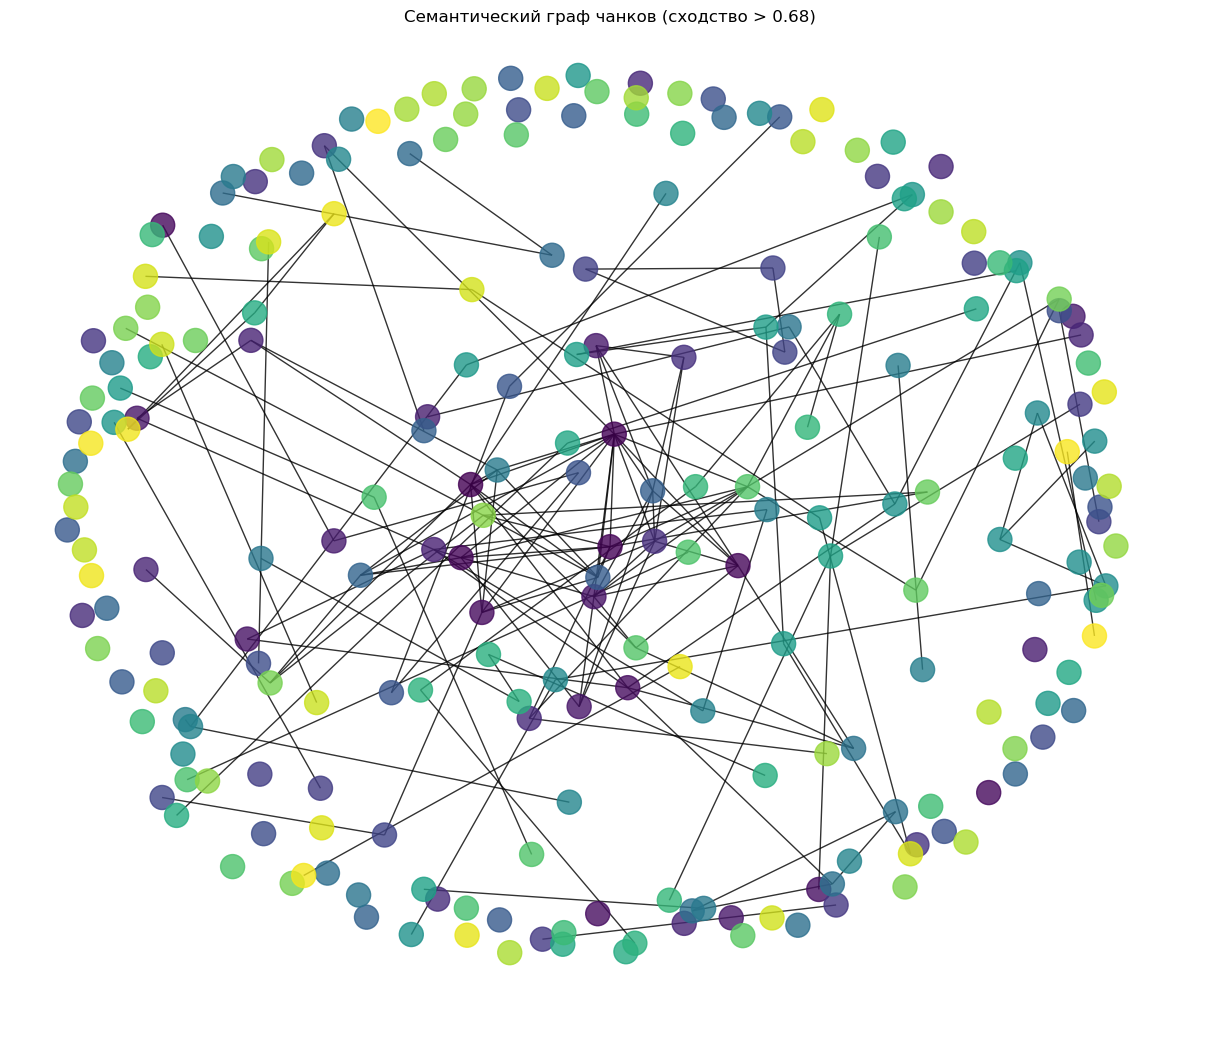

In [ ]:
import matplotlib.pyplot as plt

SEED = 42

pos = nx.spring_layout(G, k=0.5, iterations=50, seed=SEED)
node_colors = range(len(G.nodes))
plt.figure(figsize=(12, 10))
nx.draw(G, pos, node_size=300, with_labels=False, alpha=0.8, node_color=node_colors)
plt.title(f'Семантический граф чанков (сходство > {THRESHOLD})')
plt.show()

<img src="https://media1.tenor.com/m/veM7Wd7HmnMAAAAC/shylily-raf.gif" width="300" height="150">